# **Load The Data** 

In [142]:
import pandas as pd
import numpy as np
# Load pickled data
import pickle

training_file = "train.p"
validation_file="valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
#print(train)
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
# print("trainX")
# print(X_train[0:5])
# print("$$$$$$$$$$$$")
# print(y_train)
# print("$$$$$$$$$$$$")
train_sizes, train_coords = train['sizes'], train['coords']
valid_sizes, valid_coords = valid['sizes'], valid['coords']
test_sizes, test_coords = test['sizes'], test['coords']
# print("$$$$$$$$$$$$")
# print("trainsize")
# print(train_sizes)
# print("$$$$$$$$$$$$")
# print("train_coords")
# print(train_coords)
print("Done importing images.")


Done importing images.


In [143]:
signnames = pd.read_csv('./signnames.csv')
signnames.set_index('ClassId',inplace=True)

def get_name_from_label(label):
    # Helper, transofrm a numeric label into the corresponding strring
    return signnames.loc[label].SignName

# **Dataset Summary & Exploration**

In [144]:
# Number of training examples
n_train = X_train.shape[0]

# Number of validation examples
n_validation = X_valid.shape[0]

# Number of testing examples.
n_test = X_test.shape[0]

#the shape of a traffic sign image
image_shape =  X_train.shape

# numbre of classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Number of validation examples =", n_validation)
print("Image data shape =", X_train.shape[1:])
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Number of validation examples = 4410
Image data shape = (32, 32, 3)
Number of classes = 43


# **Data exploration visualization.**

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
%matplotlib inline


In [146]:
counter = Counter(y_train)
print("Train example per class mean {} min {} max {}".format(int(np.mean(list(Counter(y_train).values()))),
                                                    np.min(list(Counter(y_train).values())) ,
                                                    np.max(list(Counter(y_train).values())) ))
print("Most common signs:")
for el in counter.most_common(10):
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))
print()
print("Most rare signs:")
for el in sorted(counter.items(),key=lambda x: x[1])[:10]:
    print("'{}'".format(get_name_from_label(el[0])),' train samples: {}'.format(el[1]))

Train example per class mean 809 min 180 max 2010
Most common signs:
'Speed limit (50km/h)'  train samples: 2010
'Speed limit (30km/h)'  train samples: 1980
'Yield'  train samples: 1920
'Priority road'  train samples: 1890
'Keep right'  train samples: 1860
'No passing for vehicles over 3.5 metric tons'  train samples: 1800
'Speed limit (70km/h)'  train samples: 1770
'Speed limit (80km/h)'  train samples: 1650
'Road work'  train samples: 1350
'No passing'  train samples: 1320

Most rare signs:
'Go straight or left'  train samples: 180
'Dangerous curve to the left'  train samples: 180
'Speed limit (20km/h)'  train samples: 180
'End of no passing'  train samples: 210
'End of no passing by vehicles over 3.5 metric tons'  train samples: 210
'End of all speed and passing limits'  train samples: 210
'Pedestrians'  train samples: 210
'Bicycles crossing'  train samples: 240
'Road narrows on the right'  train samples: 240
'Keep left'  train samples: 270


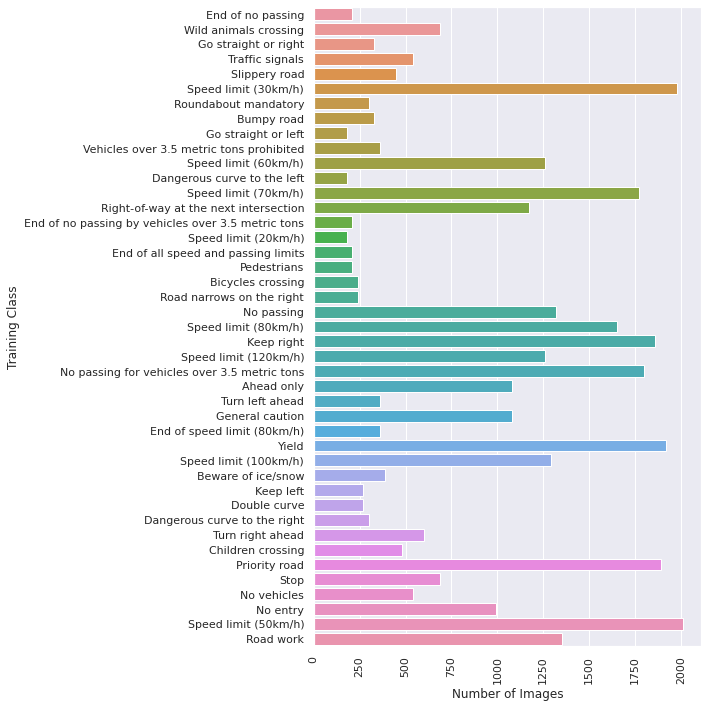

In [147]:
counts = pd.DataFrame(columns=['sign_label','training_samples_count'],data=[(label, count) for label, count in counter.items()])
counts['sign'] = counts.sign_label.apply(get_name_from_label)

plt.figure(figsize=(10,10))
sns.set(font_scale=1)
sns.barplot(data=counts,x='training_samples_count',y='sign')
plt.xticks(rotation=90)
plt.ylabel('Training Class')
plt.xlabel('Number of Images');
plt.tight_layout()
#plt.savefig('training_set_counts.png')

#generate random image max 5 raw & clos

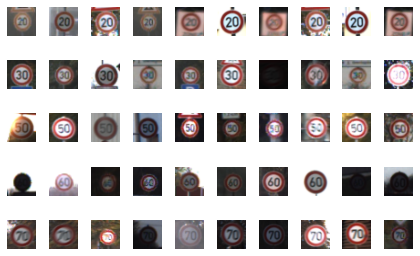

In [8]:
def get_random_samples(n_max):
    selected = list()
    n_raw=5
    for current_label in range(n_raw):
        found=0
        while found<n_max:
            ii = np.random.randint(len(y_train))
            
            if current_label == y_train[ii]:
                selected.append(ii)
                found+=1

    assert len(selected) ==  n_raw*n_max
    return list(selected)
    plt.figure(figsize=(12, 16))


count=0
cols = 10
for ii in get_random_samples(cols):
    count+=1
    plt.subplot(5,cols,count)
    plt.imshow(X_train[ii])
    plt.axis('off')
plt.tight_layout()
#plt.savefig('random_examples.png')

#**Pre-process the Data Set** 

In [170]:
import cv2

#generate random value of image
def someRandomImageId(nb = n_train):
    return int(np.random.rand()*nb)

#normalize the data
def normalize_features_pos(img_):
    return ((img_.astype(np.float32) - 128.) / 128.)

# rectify Coords  for selecting ROI
def rectifyCoords(nb, sizes, coords):
    rectified = []
    for j in range(0, nb):
        x_ratio = image_shape[1] / sizes[j][0]
        y_ratio = image_shape[2] / sizes[j][1]
        rectified.append((int(coords[j][0]*x_ratio), int(coords[j][1]*y_ratio), \
                          int(coords[j][2]*x_ratio), int(coords[j][3]*y_ratio)))
    return rectified

#resize image size
def resizeSize(img, x=32, y=32):
    return cv2.resize(img,(x, y), interpolation = cv2.INTER_CUBIC).astype(np.uint8)

#crop roi in image
def crop(img, ROI):
    return img[(ROI[1]):(ROI[3]),(ROI[0]):(ROI[2])]

#add a new roi
def addROI(img, ROI, color=(255,0, 0)):
    copy = X_train[i].copy()
    return cv2.rectangle(copy,(ROI[0],ROI[1]),(ROI[2],ROI[3]),color)
    
#rotate randomly the images by a small angle [-15°, 15°] 
def rotateImage(image, ROI, angle=None,  verbose=False):
    if angle == None:
        angle = np.random.rand()*30-15
    image_center = ((ROI[2]-ROI[0])/2+ROI[0], (ROI[3]-ROI[1])/2+ROI[1])
    rot_mat = cv2.getRotationMatrix2D(image_center,angle,1.0)
    result = cv2.warpAffine(image, rot_mat, dsize=image.shape[0:2],flags=cv2.INTER_LINEAR)
    if verbose:
        print("Rotation : {}°".format(angle))
    return result

rectified_train_coords = rectifyCoords(n_train, train_sizes, train_coords)
rectified_valid_coords = rectifyCoords(n_validation, valid_sizes, valid_coords)
rectified_test_coords  = rectifyCoords(n_test,  test_sizes,  test_coords)

def sharpen_img(img):
    gb = cv2.GaussianBlur(img, (5,5), 20.0)
    return cv2.addWeighted(img, 2, gb, -1, 0)

def transform_img(img_in):
    img_in = img_in.copy()
    img_out= sharpen_img(img_in)
    img_out = cv2.cvtColor(img_in, cv2.COLOR_BGR2GRAY)

    img_out[:,:,0] = cv2.equalizeHist(img_out[:,:,0])
    return img_out[:,:,0]

#Augmenting function
def augment_img(id_img):
    #crop ROI
    crop_ROI = crop(X_train[id_img], rectified_train_coords[id_img])
    #Resize ROI (32,32)
    Resized_ROI=resizeSize(crop_ROI)
    #grayscale ROI
    Gray_ROI=cv2.cvtColor(Resized_ROI, cv2.COLOR_BGR2GRAY)
    #normalize ROI
    normalize_ROI=normalize_features_pos(Gray_ROI)
    #Rotate ROI by a small angle [-15°, 15°] 
    rotated_ROI = rotateImage(normalize_ROI, rectified_train_coords[id_img], verbose=1)
    return rotated_ROI

#print Augmenting image
def plotAugmentation(*argv, figsize=(20, 5), save=None):
    fig = plt.figure(figsize=figsize)
    for i in range(0, len(argv[0])):    
        ax=fig.add_subplot(1,len(argv[0]),i+1)        
        ax.imshow(argv[0][i][1])
        ax.set_title(argv[0][i][0])
    if save != None:
        plt.savefig(save)
    plt.show() 

print("Augmenting functions defined.")

Augmenting functions defined.


# **Region of interst Cropping** &  **Normalize**
- Neural networks offer much better results when the data is normalized because it creates more variation in the data values. Practically speaking normalizing the data means that the input values range from -1 to 1 instead of being between 0 and 255 in the case of images.
- In order to add more training data and to make the network more accurate, I rotate randomly the images by a small angle [-15°, 15°] around the center of the Region Of Interest.

Rotation : 4.21976456395458°


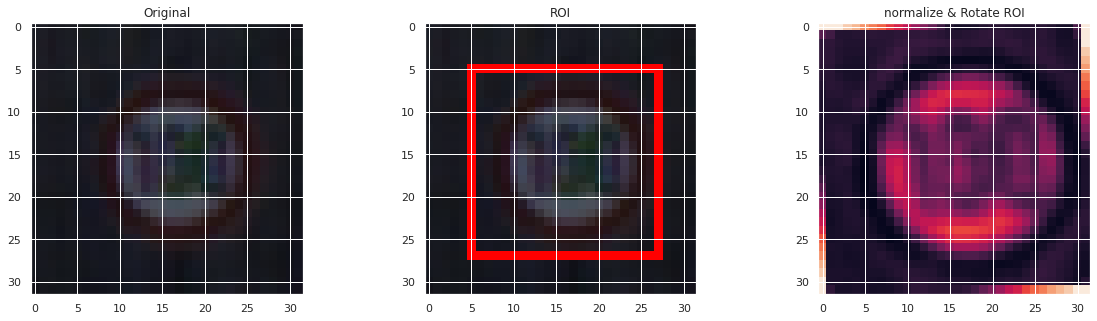

In [172]:
i = someRandomImageId()
#i=2010 max libel
arguments = (('Original', X_train[i]), ('ROI', addROI(X_train[i], rectified_train_coords[i])),('normalize & Rotate ROI', augment_img(i)))
plotAugmentation(arguments)

In [173]:
# Transform all images and augment training datfa
import time 
start_time = time.time()

X_train_augmented = np.zeros(shape=(X_train.shape))
X_valid_augmented = np.zeros(shape=(X_valid.shape))
X_test_augmented = np.zeros(shape=(X_test.shape))
y_train_augmented = y_train.copy()

for i in range(0, n_train):
    X_train_augmented[i] = augment_img(X_train[i], rectified_train_coords[i])
    
for j in range(0, n_validation):
    X_valid_augmented[j] = augment_img(X_valid[j], rectified_valid_coords[j])
    
for k in range(0, n_test):
    X_test_augmented[k] = normalize_features_pos(X_test[k])

print("Dataset augmented in {} seconds.".format(time.time() - start_time))

TypeError: ignored